In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '-1'
import importlib
import tensorflow as tf
from tensorflow import keras
import yaml
import os
import numpy as np
import json
import matplotlib.pyplot as plt

import dataset
import utils
importlib.reload(dataset)
importlib.reload(utils)
from dataset import *
import hydra
from hydra import compose, initialize
from omegaconf import OmegaConf



2023-05-12 11:32:43.510073: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
/root/jreymond/miniconda3/envs/py_cpu/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/root/jreymond/miniconda3/envs/py_cpu/lib/python3.9/site-packages/tensorflow_addons/utils/ensure_tf_install.py:53: UserWarning: Tensorflow Addons supports using Python ops for all Tensorflow versions above or equal to 2.9.0 and strictly below 2.12.0 (nightly versions are not supported). 
 The versions of TensorFlow you are currently using is 2.12.0 and is not supported. 
Some things might work, some things might n

# Wallerlab

In [8]:
config_name = "wallerlab_reconstruction"
model_path = '/home/jreymond/lensless_ml/stored_models/2023-04-25/wallerlab_unet.pb'

hydra.core.global_hydra.GlobalHydra.instance().clear()
initialize(config_path="configs", job_name="test_app")
config = compose(config_name= config_name)

/tmp/ipykernel_4101805/3938903348.py:5: UserWarning: 
The version_base parameter is not specified.
Please specify a compatability version level, or None.
Will assume defaults for version 1.1
  initialize(config_path="configs", job_name="test_app")


In [29]:
num_samples = 5

print(config['dataset']['len'])
dataset_generator = WallerlabGenerator(config['dataset'],  
                                       indexes=np.arange(config['dataset']['len']), 
                                       batch_size=config['batch_size'],
                                       greyscale=config['greyscale'], 
                                       seed=config['seed'])

X, Y = dataset_generator.get_samples(num_samples)


24999
/scratch/bezzam/DiffuserCam_mirflickr/dataset/diffuser_images/im23544.npy
/scratch/bezzam/DiffuserCam_mirflickr/dataset/diffuser_images/im18447.npy
/scratch/bezzam/DiffuserCam_mirflickr/dataset/diffuser_images/im10436.npy
/scratch/bezzam/DiffuserCam_mirflickr/dataset/diffuser_images/im21630.npy
/scratch/bezzam/DiffuserCam_mirflickr/dataset/diffuser_images/im2706.npy


In [31]:
X.dtype

dtype('float32')

In [38]:
tests = [43, 65, 157, 189, 326, 394, 408, 643, 740]
X_test = np.zeros((len(tests), *X.shape[1:]), dtype=np.float32)
# Y_test = np.zeros((len(tests), *X.shape[1:]), dtype=np.float32)
Y_test = []
for index, i in enumerate(tests):
    filename = '/home/jreymond/lensless_ml/sample_imgs/wallerlab/diffuser/im' + str(i) + '.npy'
    X_test[index]= np.load(filename).transpose((2, 0, 1)).astype(np.float32)
    filename = '/home/jreymond/lensless_ml/sample_imgs/wallerlab/lensed/im' + str(i) + '.npy'
    Y_test.append(np.load(filename).transpose((2, 0, 1)).astype(np.float32))
num_samples = len(tests)
print(X_test.dtype)
X = X_test
Y = Y_test


float32


In [27]:

model = tf.saved_model.load(model_path)

In [36]:
Y_gen = model(tf.convert_to_tensor(X))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

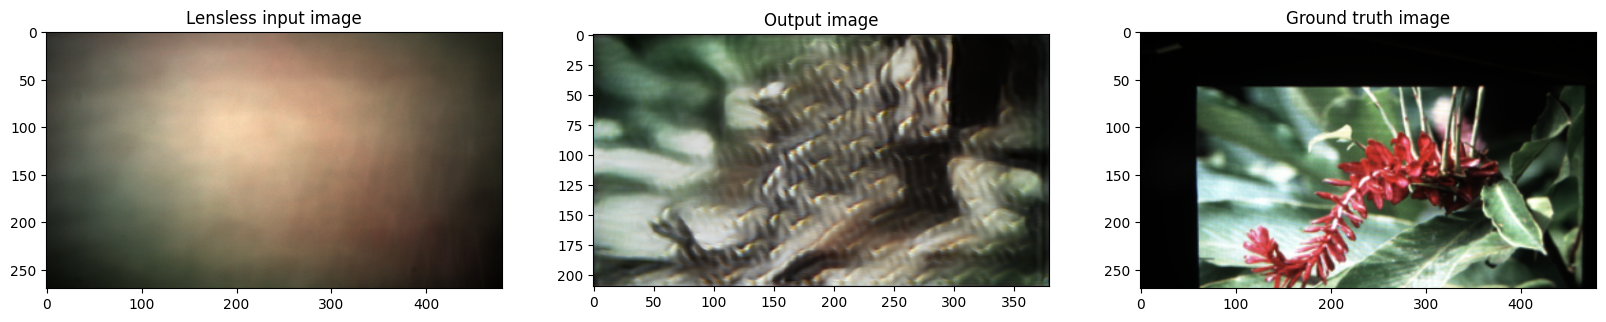

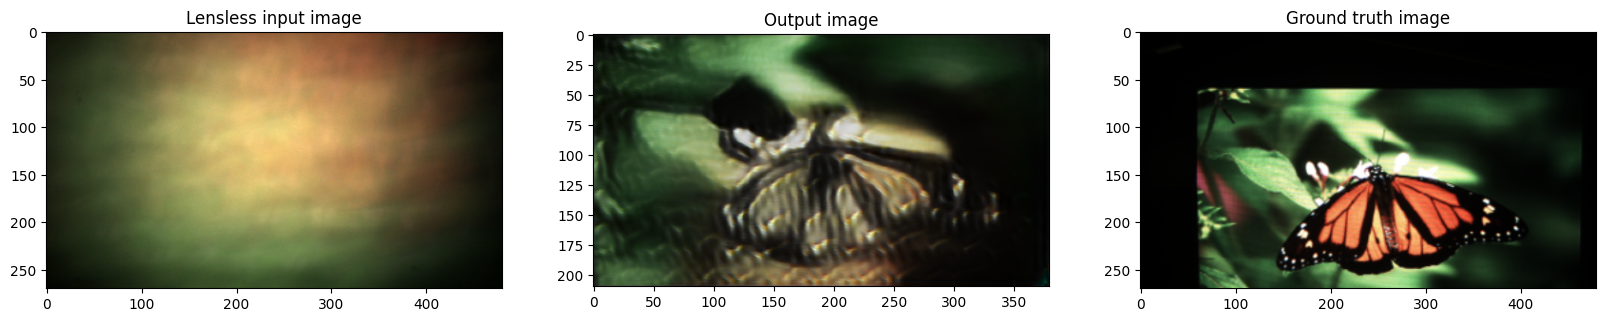

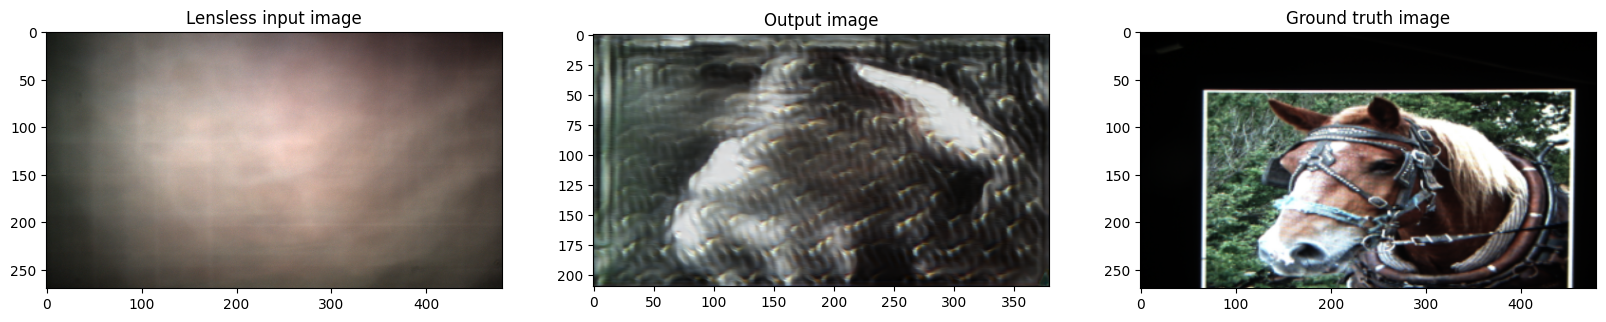

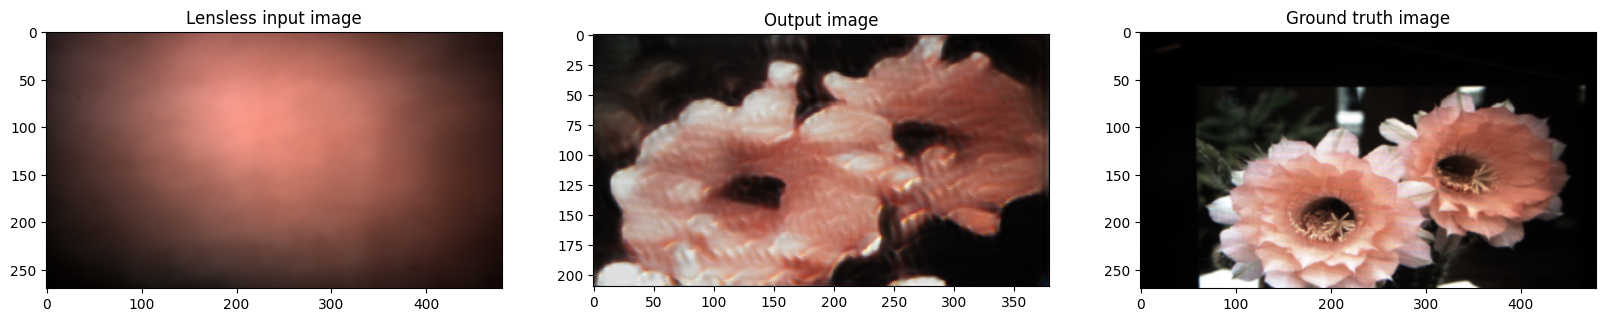

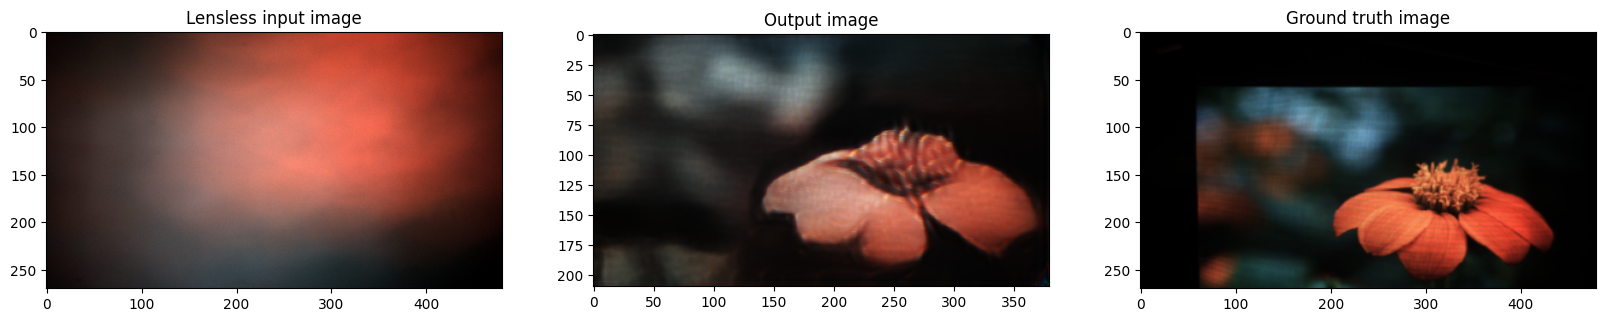

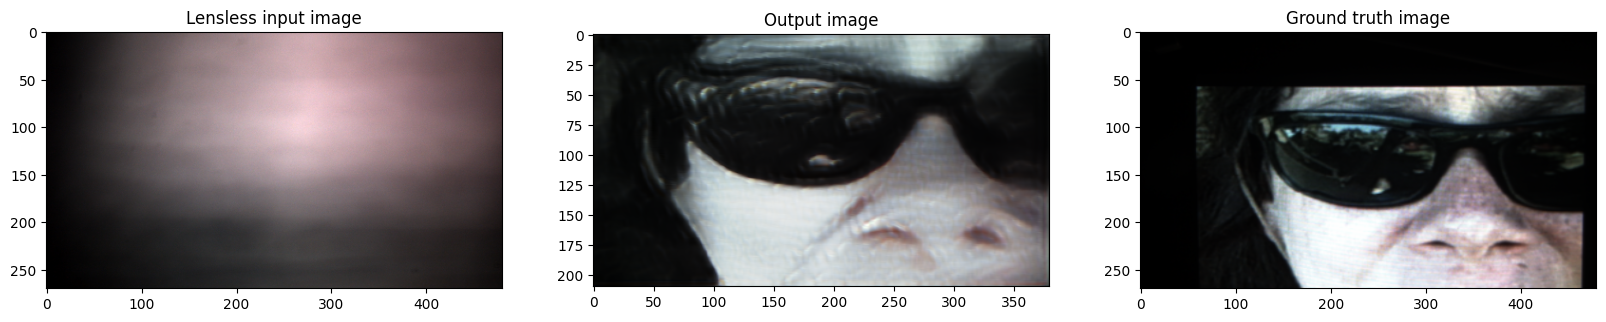

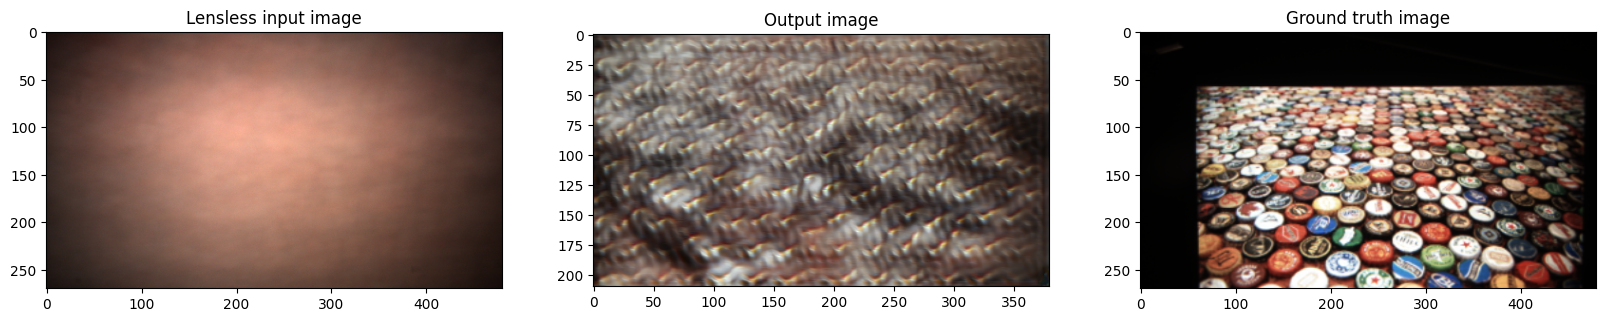

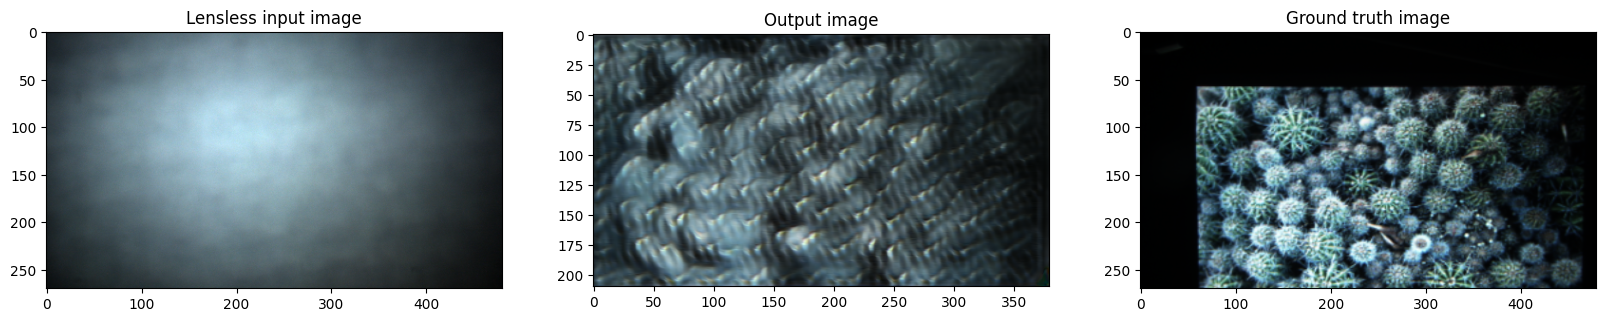

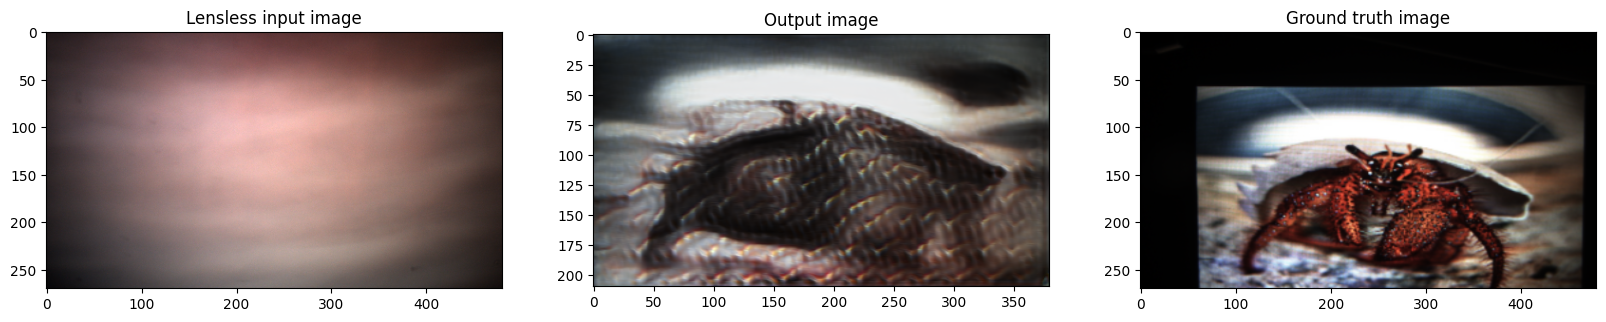

In [47]:
for i in range(num_samples):
    measurement = dataset_generator.to_plottable_measurement(X[i])[:,:,::-1]
    output = dataset_generator.to_plottable_output(Y_gen[i].numpy())[:,:,::-1]
    ground_truth = dataset_generator.to_plottable_output(Y[i])[:,:,::-1]

    fig1, ax = plt.subplots(1, 3, figsize=(20,5))
    ax[0].imshow(measurement)
    ax[0].set_title('Lensless input image')

    ax[1].imshow(output)
    ax[1].set_title('Output image')

    ax[2].imshow(ground_truth)
    ax[2].set_title('Ground truth image');

    fig1.savefig('figs/wallerlab_' + str(i), dpi=250)

# Flatnet

In [2]:
config_path = "configs"
config_name = "wallerlab_reconstruction"

# config_path =  'outputs/2023-05-10/09-44-12/tensorflow/.hydra'
# config_name =  'config'

model_path = '/root/jreymond/lensless_ml/outputs/2023-05-10/09-44-12/tensorflow/models/unet128.pb'

hydra.core.global_hydra.GlobalHydra.instance().clear()
initialize(config_path=config_path, job_name="test_app")
config = compose(config_name= config_name)

/tmp/ipykernel_838850/3435142528.py:10: UserWarning: 
The version_base parameter is not specified.
Please specify a compatability version level, or None.
Will assume defaults for version 1.1
  initialize(config_path=config_path, job_name="test_app")


In [3]:
dataset_config = dict(config['dataset'])
# TODO : temporal
dataset_config['use_cropped_dataset'] = True
# flatnet
# dataset_config['measure_cropped_folder'] = 'measurements_cropped'
# phlatnet
dataset_config['measure_cropped_folder'] = 'measures_cropped'

indexes = np.arange(dataset_config['len'])

num_samples = 50

# Data Generators
data_args = dict(batch_size=config['batch_size'], 
                greyscale=config['greyscale'],
                use_crop=config['use_crop'], 
                seed=config['seed'])

dataset_generator = get_dataset(config['dataset']['name'], dataset_config, indexes, data_args)

print(dataset_generator.in_dim)

X, Y = dataset_generator.get_samples(num_samples)

209
10000 9791
some of the samples do not match : list(groundtruths) != list(measurements),  x length: 9791 y length: 10000 diff length: 209
final length: 9791
in dim:  (4, 1280, 1408)
(4, 1280, 1408)


In [ ]:
# len(np.unique(Y)) # ahhh maybe due to noise
print(Y.min(), Y.max())  # seems correct ? 
print(X.min(), X.max())

-1.0 1.0


In [47]:
path_test = '/scratch/jreymond/ICCV-2019-FlatNet-Dataset/Display-Captures/measurements_cropped/n04192698/n04192698_61010.npy'
# path_test = '/scratch/jreymond/phlatnet/measures_cropped/n01440764/n01440764_457.npy'

arr = np.load(path_test)
print(arr.dtype)
# arr += np.random.normal(size=arr.shape, scale=0)
print(np.min(arr), np.max(arr))

# plt.imshow(arr[:,:,0])

uint16
25999 45821


In [43]:
res = dataset_generator._get_x(path_test)
print(np.min(res), np.max(res))

-0.9999879 -0.99997866


In [58]:
model = tf.saved_model.load(model_path)


AttributeError: '_UserObject' object has no attribute 'summary'

In [49]:
Y_gen = model(tf.convert_to_tensor(X))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

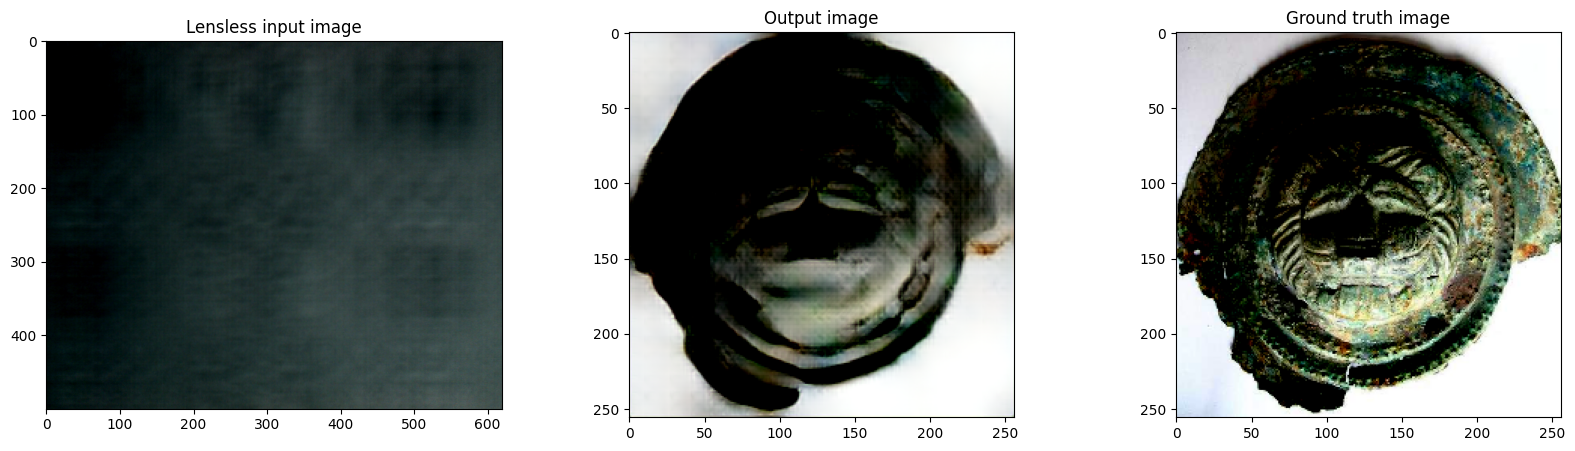

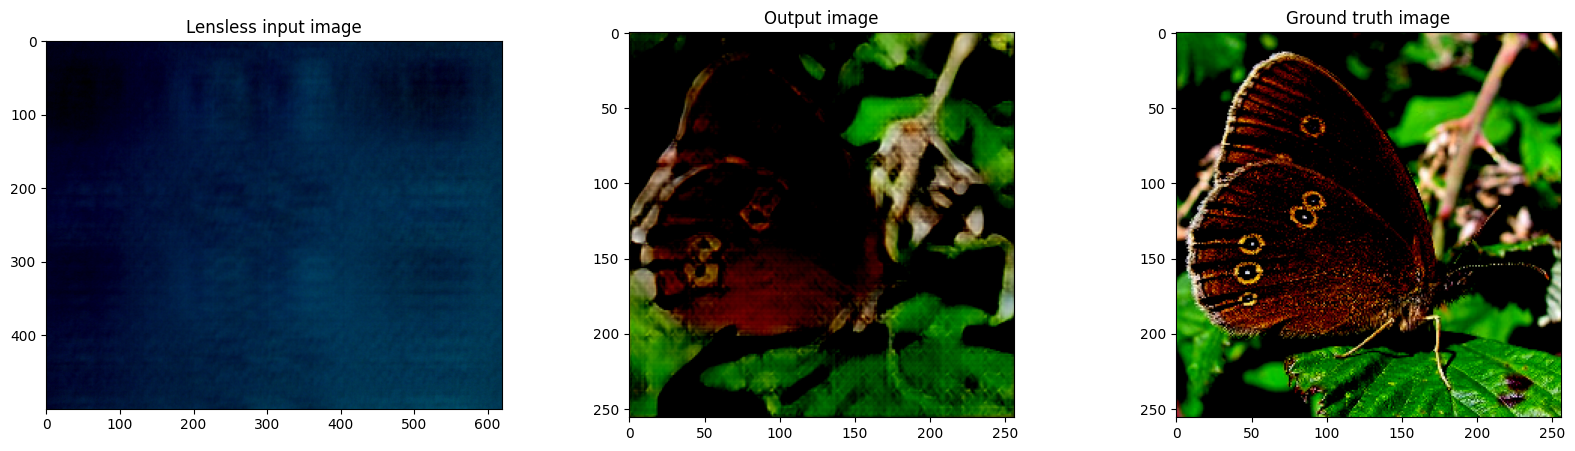

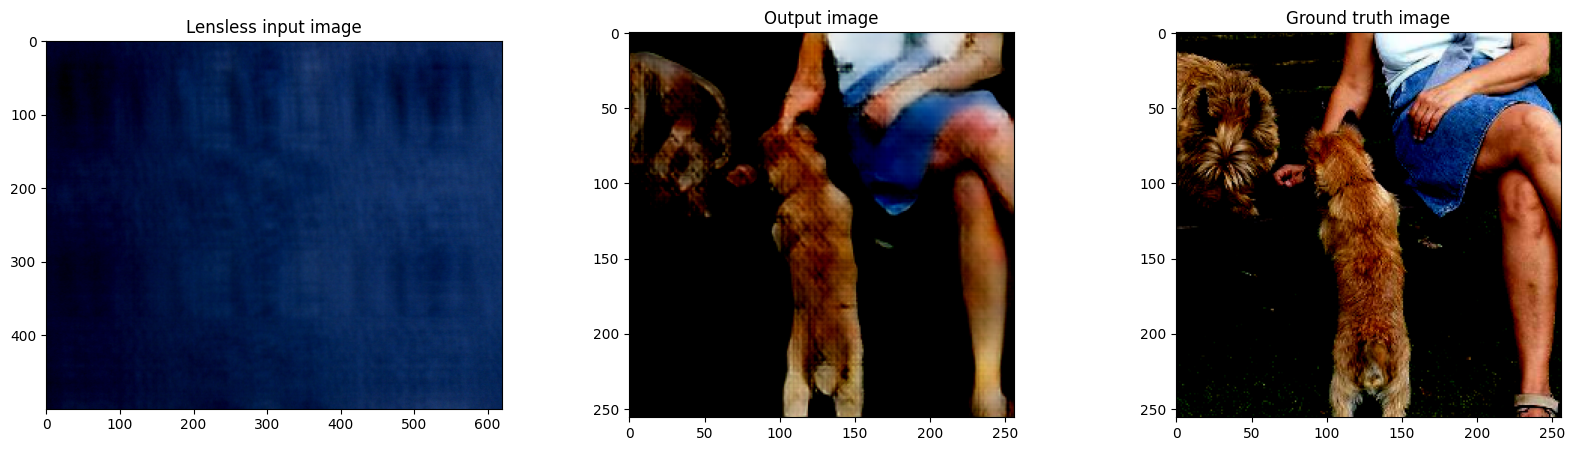

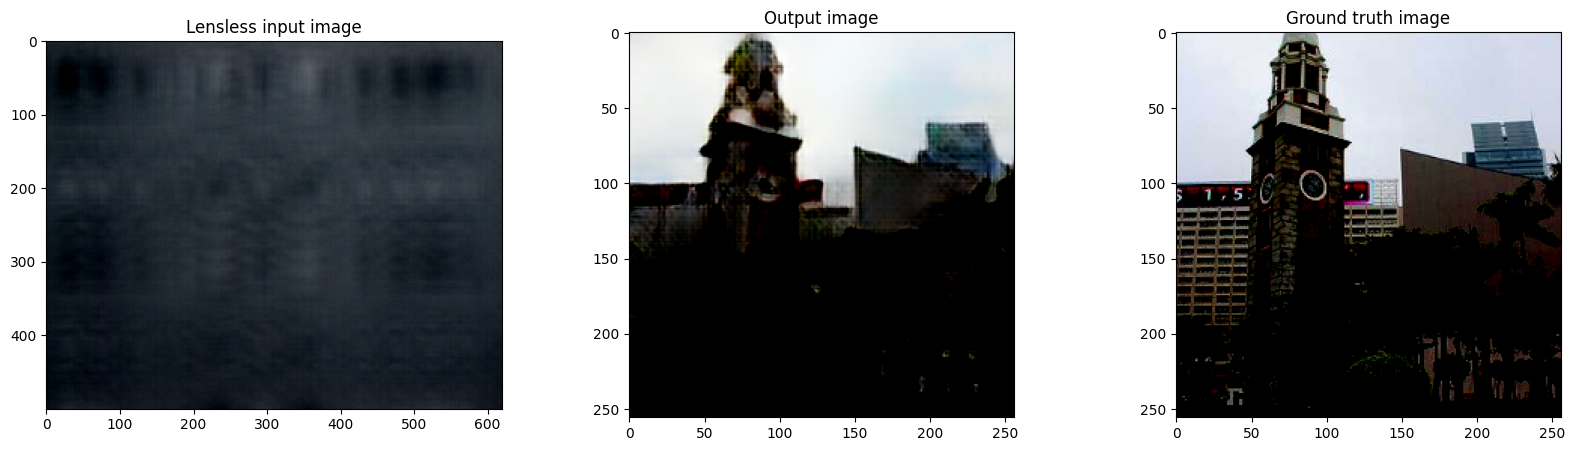

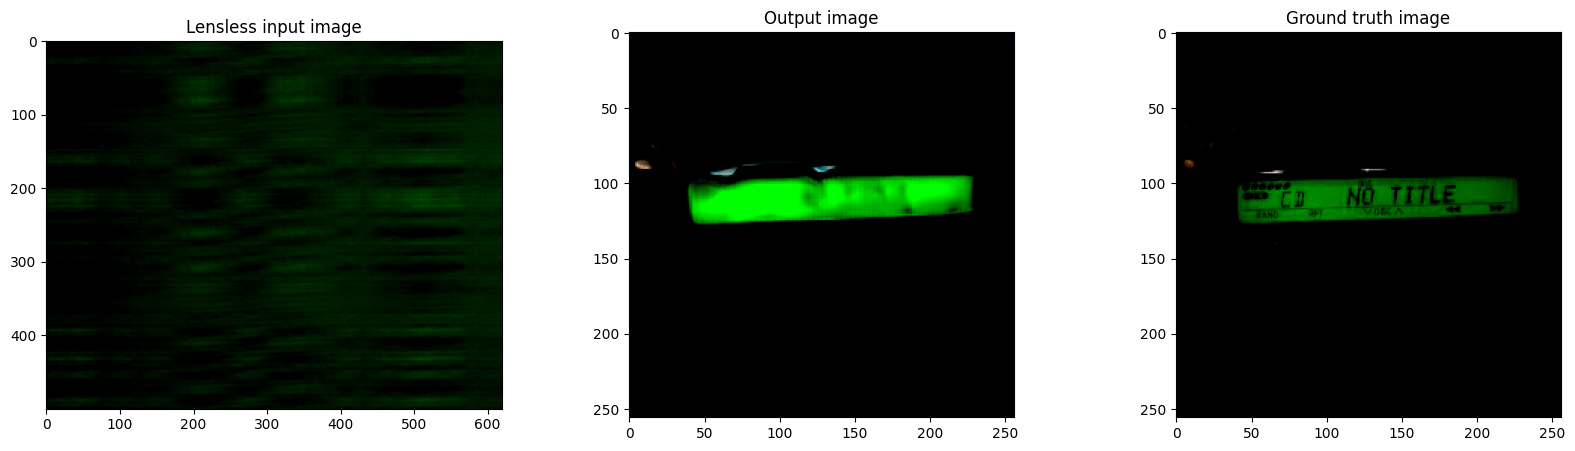

In [57]:
for i in range(num_samples):
    measurement = dataset_generator.to_plottable_measurement(X[i])
    output = dataset_generator.to_plottable_output(Y_gen[i].numpy())
    ground_truth = dataset_generator.to_plottable_output(Y[i])

    fig1, ax = plt.subplots(1, 3, figsize=(20,5))
    ax[0].imshow(measurement)
    ax[0].set_title('Lensless input image')

    ax[1].imshow(output)
    ax[1].set_title('Output image')

    ax[2].imshow(ground_truth)
    ax[2].set_title('Ground truth image');

    fig1.savefig('figs/flatnet/flatnet_128_no_noise_' + str(i), dpi=250)